# TAREA FINAL: Datos de vivienda

### Nombre: Sergio Casares Fernández


El negocio inmobiliario es uno de los motores de la economía de España, el carácter turístico de nuesta península hace que sean muchos los inversores extranjeros que se decidan por buscar una inversión de bajo riesgos en nuestras ciudades costeras o grandes urbes. Muchas de estas inversiones se hacen sobre grandes bolsas de inmuebles que deben ser analizados previamente para comprobar la rentabilidad del porfolio

Todas las cuestiones se deben realizar sobre el conjunto de casos que representen viviendas ubicadas en zonas residenciales (alta, media y baja densidad)

MUY IMPORTANTE: En las otras prácticas he detectado colaboraciones involucrando varias personas y he sido flexible aunque a algunos os lo he mencionado en las correcciones, porque al final el trabajo de analista de datos es un trabajo colaborativo. Sin embargo, este trabajo es individual, así que cuidado con las colaboraciones.

### 1. Inicializar y cargar el contexto spark

Inicializamos el contexto Spark y todas la dependencias necesarias

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
import urllib.request
f = urllib.request.urlretrieve ("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "kddcup.data_10_percent.gz")

In [4]:
from pyspark import SparkContext
from pyspark.sql.functions import desc
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import *
from pyspark.sql import SQLContext, functions as F, Row
from pyspark.sql.types import *
from pyspark.sql.types import StringType, IntegerType

# Librería para dar formato a las salidas obtenidas
import pandas as pd
import numpy as np
# Librería para aplicar expresiones regulares en el parseado
import re
# librería para parsear las fechas con formato date
from datetime import datetime
# Librería que permite descargar información de una url desde python
import urllib
from urllib.request import urlretrieve
# Librería para llamar a funciones relacionadas con el sistema operativo
import os



In [5]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## Importar Dataset y Parseado

Además de importar el dataset, a la hora de parsear, separaremos las columnas por el delimitador ';' y seleccionar las observaciones que sean de RL, RM y RH.

En total son 168 observaciones que se eliminar del archivo.

In [6]:
path = '/content/BDpracticafinalCSV.csv'

raw_data = sc.textFile(path)

In [28]:
raw_data.take(1)

['Order;MS Zoning;Lot Frontage;Lot Area;Land Contour;Land Slope;Overall Qual;Year Built;Year Remod/Add;Mas Vnr Type;Exter Qual;Bsmt Cond;Total Bsmt SF;Heating QC;Central Air;Full Bath;Half Bath;Bedroom AbvGr;Kitchen AbvGr;Kitchen Qual;TotRms AbvGrd;Garage Cars;Garage Area;Garage Cond;Pool Area;Pool QC;Mo Sold;Yr Sold;SalePrice']

In [29]:
#Quitar encabezados

raw_data_encabezado = raw_data.take(1)[0]
raw_data =  raw_data.filter(lambda x: x != raw_data_encabezado)


In [30]:
#PARSEAMOS LOS DATOS

raw_data = raw_data.map(lambda x: x.split(";")) 

In [31]:
def cambios(x):
  if x == 'rL':
    return 'RL'
  elif x == 'Rl':
    return 'RL'
  elif x == 'RL':
    return 'RL'
  elif x == 'RH':
    return 'RH'
  elif x == 'RM':
    return 'RM'
  elif x == 'FV':
    return 'ELIMINAR'
  elif x == 'RH':
    return 'ELIMINAR'
  elif x == 'C':
    return 'ELIMINAR'
  elif x == 'I':
    return 'ELIMINAR'
  elif x == 'A':
    return 'ELIMINAR'
  else:
    'ELIMINAR'

In [32]:
raw_data_final = raw_data.map(lambda x : (x[0], cambios(x[1]), x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],
                                   x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27], x[28]))

In [33]:
raw_data_final.count()

2936

In [34]:
raw_data_final_filtrado = raw_data_final.filter(lambda x: not 'ELIMINAR' in x[1])

In [35]:
raw_data_final_filtrado.count()

2768

## 2.Cuántas viviendas distintas encontramos en el dataset? ¿Se repite alguna? Tiene sentido que haya duplicadas? ¿Qué podemos hacer con las duplicadas?

In [36]:
#Relizamos un distinct de la primera columna para ver cuántas viviendas distintas existen
raw_data_final_filtrado.map(lambda x : x[0]).distinct().count()

2762

In [37]:
#Realizamos el conteo de la columna de vivienda
raw_data_final_filtrado.map(lambda x : x[0]).count()

2768

### Quitar Duplicados

Comprobamos que hay 6 viviendas repetidas, por lo que procederemos a eliminarlas

In [38]:
def duplicados(x):
    return "{0}".format(x[0])

In [39]:
m = raw_data_final_filtrado.map(lambda x: (duplicados(x),x))
m = m.reduceByKey(lambda x,y: (x))

raw_data_final_filtrado = m = m.map(lambda x: x[1])

In [40]:
raw_data_final_filtrado.count()

2762

## 3. ¿Podrías decirme el total de inmuebles y el precio medio (Sale Price) de cada zona (MS Zoning)?

Hallar la media y contar el número de observaciones por zona

In [41]:
#Seleccionamos las collumnas de Zona y Sale Price
rdd_2 = raw_data_final_filtrado.map(lambda x: (x[1], float(x[28])))
rdd_2.take(5)

[('RL', 215000.0),
 ('RL', 244000.0),
 ('RL', 191500.0),
 ('RL', 236500.0),
 ('RL', 189000.0)]

In [42]:
#Realizamos un conteo de cada uno de los tres tipos
conteo_rdd = rdd_2.map(lambda x: (x[0],1)).reduceByKey(lambda a,b: a + b)
conteo_rdd.collect()

[('RL', 2273), ('RH', 27), ('RM', 462)]

In [43]:
#Realizamos la suma de los tres valores
suma_rdd = rdd_2.reduceByKey(lambda a, b: a + b)
suma_rdd.collect()

[('RL', 434786831.0), ('RH', 3683334.0), ('RM', 58573004.0)]

In [44]:
#Realizamos la media de cada grupo por medio de dividir la suma entre el conteo
media_rdd = suma_rdd.join(conteo_rdd).map(lambda x:(x[0],(x[1][0]/x[1][1])))
media_rdd.collect()

[('RL', 191283.25164980203),
 ('RH', 136419.77777777778),
 ('RM', 126781.39393939394)]

RH residencial alta densidad <- 27 viviendas y 136.419 de media

RL residencial baja densidad <- 2273 viviendas y 191.283 de media

RM residencial media densidad <- 462 viviendas y 126.781 de media

## 4. Media de Total Bsmt SF por cada década de construcción calculada a partir de Year Built. 
## ¿Cuál es la decada de construcción con viviendas mejor acondicionadas para el frío (Heating QC)?

Media de Total BsmT sf.
Lo primero que hacemos es seleccionar las variables que necesitamos.

Generamos una función que nos separe por décadas (al haber varios siglos, seleccionamos los tres primeros dígitos y le añadimos '0s'.

Al igual que en ejercicio anterior, realizamos la suma y el conteo y obtenemos la media de cada una de las décadas.

In [45]:
import statistics as stats 

In [46]:
#Columna 7, Year Built
#Columna 12, Total Bsmt SF
#Columna 13, Heating QC
decadas_1 = raw_data_final_filtrado.map(lambda x : [x[i] for i in [7]])
decadas_2 = raw_data_final_filtrado.map(lambda x : (x[7], float(x[12])))
decadas_3 = raw_data_final_filtrado.map(lambda x : (x[7], x[13]))

In [47]:
#Función para convertir los años a décadas
def cambio_decadas(x):
  return x[0:3] + "0s"

In [48]:
#Realizamos la comprobación
cambio_decadas('1827')

'1820s'

Media de Total Bsmt SF por década

In [49]:
decadas_cambios_suma = decadas_2.map(lambda x : (cambio_decadas(x[0]), x[1])).reduceByKey(lambda a, b: a + b)

In [50]:
decadas_cambios_conteo = decadas_2.map(lambda x : (cambio_decadas(x[0]),1)).reduceByKey(lambda a, b: a + b)

In [51]:
decadas_cambios_media = decadas_cambios_suma.join(decadas_cambios_conteo).map(lambda x:(x[0],(x[1][0]/x[1][1]))).collect()
decadas_cambios_media.sort()
decadas_cambios_media

[('1870s', 761.0),
 ('1880s', 836.0),
 ('1890s', 885.5833333333334),
 ('1900s', 720.1388888888889),
 ('1910s', 788.3009708737864),
 ('1920s', 833.9368421052632),
 ('1930s', 769.9158878504672),
 ('1940s', 706.9261744966443),
 ('1950s', 968.2955223880597),
 ('1960s', 1082.672268907563),
 ('1970s', 952.7225274725274),
 ('1980s', 1086.0),
 ('1990s', 1138.8083067092653),
 ('2000s', 1348.469079939668),
 ('2010s', 1539.0)]

Podemos observar que el valor más alto superficie del sótano en pies cuadrádos es en 2010 y la que menos en 1870, se puede observar como existe una tendencia clara a ir aumentando el valor por cada década que transcurre.

Década con mejor acondicionamiento para el frio, Heating QC

In [52]:
acondicionamiento_decadas = decadas_3.map(lambda x : (cambio_decadas(x[0]), x[1]))

In [53]:
acondicionamiento_decadas.take(5)

[('1960s', 'Fa'),
 ('1960s', 'Ex'),
 ('1990s', 'Ex'),
 ('1990s', 'Ex'),
 ('1990s', 'Gd')]

In [54]:
conteo_acondicionamiento_frio = acondicionamiento_decadas.map(lambda x: (x[1],1)).reduceByKey(lambda a,b: a + b)
conteo_acondicionamiento_frio.collect()

[('Fa', 88), ('Po', 2), ('Ex', 1358), ('Gd', 464), ('TA', 850)]

Podemos observar cómo la mayoría de los pisos presentan un acondicionamiento excelente contra el frio (con 1358 observaciones), seguido con Media (TA) y Bueno (464)

In [55]:
acondicionamiento_frio = sorted(acondicionamiento_decadas.groupByKey().mapValues(len).collect())
acondicionamiento_frio
#Realizamos el conteo de las viviendas por década

[('1870s', 3),
 ('1880s', 8),
 ('1890s', 12),
 ('1900s', 36),
 ('1910s', 103),
 ('1920s', 190),
 ('1930s', 107),
 ('1940s', 149),
 ('1950s', 335),
 ('1960s', 357),
 ('1970s', 364),
 ('1980s', 120),
 ('1990s', 313),
 ('2000s', 663),
 ('2010s', 2)]

In [56]:
acondicionamiento_frio_group = decadas_3.map(lambda x : (x[0], x[1])).reduceByKey(lambda a, b: a + b).collect()
acondicionamiento_frio_group

[('1995', 'ExExExExExExGdExExExExExExGdExExGdExExExGdGdExGdExExGdGdExExEx'),
 ('1990', 'GdExExExGdGdExTAExGdTAExGdGdGdGdExGdGd'),
 ('2003',
  'ExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExEx'),
 ('1951', 'ExTATATAExTAFaTATAExFaExTAExTATA'),
 ('1978',
  'TATATATAExTATATAGdTATAExTAExTATATATAExExTAFaTAFaTATAGdTATATAGdTATAExExTAExTATATATATA'),
 ('1977',
  'ExTAGdGdExTAExTATATATAFaTAExTATATAExTATATAFaTATATATAExFaExExTATAGdTAExTATATAExTATATATATATATAExTATATATAExTATATATAEx'),
 ('1970',
  'ExExTATATATATAExExExTAGdTAExExTATATATATATAExTATATATAExTATAExGdTAExTATAFaGdGdTAExTAGd'),
 ('2004',
  'ExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExEx'),
 ('2002',
  'ExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExExEx'),
 ('1994',
  'ExGdExExExEx

Aunque no se ha llegado a conseguir por medio de código la agrupación deseada, es cierto que se puede observar de los datos recogidos, que 2005 es el año donde más casa cuentan con un acondicionamiento Excelente, seguido por 2006 y luego por 2007.

He intentado realizados agrupación por dos elementos pero no he sido capaz.

## 5.¿Cuáles son las 10 viviendas que se vendieron por un precio más elevado por metro cuadrado en el año 2009?

Seleccionamos las columnas necesarias:

ID Vivienda = 0

Año de Venta = 27

Precio/m^2 = columna 28(Precio Venta) / columna 3(metros cuadrado) * tasa de pies a metros cuadrados (0.09203)

Procedimiento:

Realizamos un filtro para el año 2009

Ordenamos de manera descendente y obtenemos los 10 primero valores.

In [57]:
viviendas_top = raw_data_final_filtrado.map(lambda x : (x[0], x[27], float(x[28])/(float(x[3])*0.092903)))

In [58]:
viviendas_top = viviendas_top.filter(lambda x: x[1] == '2009')

In [59]:
viviendas_top = viviendas_top.sortBy(lambda x: x[2], ascending = False)
viviendas_top.take(10)

[('936', '2009', 1026.7118971897073),
 ('934', '2009', 991.0325013521444),
 ('464', '2009', 821.0570122815511),
 ('935', '2009', 807.9613655043873),
 ('408', '2009', 765.647528938273),
 ('407', '2009', 756.0368904997173),
 ('405', '2009', 717.5943367454944),
 ('933', '2009', 714.281725843034),
 ('403', '2009', 711.1872444531239),
 ('411', '2009', 701.0707829388548)]

Podemos ver que el precio más alto por metro cuadrado corresponde a la observación 936 con un valor total de 1026,71$ el m^2.

## 6.Media anual por zonas del precio de venta y metros cuadrados.

Hacemos una selección de las columans que necesitemos:

Zona a la que pertenecen = 1

Año = 7

Precio de Venta = 28

Metros cuadrados = 3

Procedimiento:

Realizamos el cambio de pies a metros

Creamos tres rdd por medio de un filter para filtrar las observaciones por zonas (RL, RH y RM)

Realizamos la media anual tanto para el precio como los metros cuadrados para cada una de las tres zonas.

In [60]:
seleccion_6 = raw_data_final_filtrado.map(lambda x: (x[1], x[7], float(x[28]), (float(x[3])*0.092903)))

In [61]:
seleccion_6.take(5)

[('RL', '1960', 215000.0, 2951.52831),
 ('RL', '1968', 244000.0, 1036.79748),
 ('RL', '1992', 191500.0, 464.979515),
 ('RL', '1995', 236500.0, 500.654267),
 ('RL', '1999', 189000.0, 696.7725)]

In [62]:
media_zona_RL = seleccion_6.filter(lambda x: 'RL' in x[0])
media_zona_RH = seleccion_6.filter(lambda x: 'RH' in x[0])
media_zona_RM = seleccion_6.filter(lambda x: 'RM' in x[0])

### ZONA RL

In [63]:
#PRECIO
zona_RL = media_zona_RL.map(lambda x: (x[1], x[2]))
suma_RL = zona_RL.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RL = zona_RL.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_precio_RL = suma_RL.join(conteo_RL).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [64]:
media_precio_RL.take(10)

[('1995', 247500.0),
 ('1990', 215951.57894736843),
 ('2003', 247085.01408450704),
 ('1951', 133006.25),
 ('1978', 173014.63414634147),
 ('1977', 170496.22641509434),
 ('1970', 156413.63636363635),
 ('2004', 231581.484375),
 ('2002', 228877.67441860464),
 ('1994', 229898.67567567568)]

In [65]:
#Precio / Metro Cuadrado
zona_RL = media_zona_RL.map(lambda x: (x[1], x[3]))
suma_RL = zona_RL.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RL = zona_RL.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_superficie_RL = suma_RL.join(conteo_RL).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [66]:
media_superficie_RL.take(10)

[('1995', 1071.971754548387),
 ('1990', 1017.370973736842),
 ('2003', 950.073183746479),
 ('1951', 1027.3678255),
 ('1978', 906.4523050731707),
 ('1977', 1053.8583271509433),
 ('1970', 953.5732834545455),
 ('2004', 1007.78851825),
 ('2002', 985.8499069069769),
 ('1994', 1141.0396677837837)]

### ZONA RH

In [67]:
#PRECIO
zona_RH = media_zona_RH.map(lambda x: (x[1], x[2]))
suma_RH = zona_RH.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RH = zona_RH.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_precio_RH = suma_RH.join(conteo_RH).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [68]:
media_precio_RH.take(10)

[('1920', 67500.0),
 ('1925', 121800.0),
 ('1949', 145000.0),
 ('1928', 76000.0),
 ('1938', 160000.0),
 ('1911', 130000.0),
 ('1977', 144000.0),
 ('2002', 190000.0),
 ('1993', 137000.0),
 ('1999', 184000.0)]

In [69]:
#Precio / Metro Cuadrado
zona_RH = media_zona_RH.map(lambda x: (x[1], x[3]))
suma_RH = zona_RH.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RH = zona_RH.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_superficie_RH = suma_RH.join(conteo_RH).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [70]:
media_superficie_RH.take(10)

[('1920', 910.4494),
 ('1925', 872.544976),
 ('1949', 582.50181),
 ('1928', 836.127),
 ('1938', 585.2889),
 ('1911', 791.998075),
 ('1977', 780.3851999999999),
 ('2002', 815.038019),
 ('1993', 335.565636),
 ('1999', 544.225774)]

### ZONA RM

In [71]:
#PRECIO
zona_RM = media_zona_RM.map(lambda x: (x[1], x[2]))
suma_RM = zona_RM.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RM = zona_RM.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_precio_RM = suma_RM.join(conteo_RM).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [72]:
media_precio_RM.take(10)

[('1978', 112000.0),
 ('1927', 123333.33333333333),
 ('1957', 136050.0),
 ('1938', 125466.66666666667),
 ('1948', 132111.11111111112),
 ('1921', 100125.0),
 ('2004', 179546.5),
 ('1941', 95928.57142857143),
 ('1970', 90185.0),
 ('1939', 122292.0)]

In [73]:
#Precio / Metro Cuadrado
zona_RM = media_zona_RM.map(lambda x: (x[1], x[3]))
suma_RM = zona_RM.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b)
conteo_RM = zona_RM.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b : a+b)
media_superficie_RM = suma_RM.join(conteo_RM).map(lambda x:(x[0],(x[1][0]/x[1][1])))

In [74]:
media_superficie_RM.take(10)

[('1978', 829.62379),
 ('1927', 668.6383748333333),
 ('1957', 656.638404),
 ('1938', 605.7275599999999),
 ('1948', 798.6561233333333),
 ('1921', 772.7207025),
 ('2004', 362.57253810000003),
 ('1941', 615.1505785714286),
 ('1970', 161.26102740000002),
 ('1939', 619.8023645000001)]

## 7.¿Podrías decirme el total de recaudación de las casas de revistimiento (Mas Vnr Type) de piedra con respecto a las de ladrillo? ¿Hay diferencia significativa?


Para poder analizar el valor total de la recaudación en función del revestimiento de las casas, lo primero que vamos a realizar es un collect distinct para saber cúales son los tipos.

In [75]:
raw_data_final_filtrado.map(lambda x : x[9]).distinct().collect()

['None', '', 'CBlock', 'Stone', 'BrkFace', 'BrkCmn']

A continuación, realizamos el filtrado para obtener tres RDD con cada uno de los tipos que necesitamos, ladrillo normal, ladrillo viso y piedra.

In [77]:
revestimientos = raw_data_final_filtrado.map(lambda x: (x[9], int(x[28])))

In [78]:
revestimiento_ladrillo_normal = revestimientos.filter(lambda x: not 'BrkFace' in x[0])\
                                              .filter(lambda x: not 'Stone' in x[0])\
                                              .filter(lambda x: not 'CBlock' in x[0])\
                                              .filter(lambda x: not 'None' in x[0])

In [79]:
revestimiento_ladrillo_viso = revestimientos.filter(lambda x: not 'BrkCmn' in x[0])\
                                            .filter(lambda x: not 'Stone' in x[0])\
                                            .filter(lambda x: not 'CBlock' in x[0])\
                                            .filter(lambda x: not 'None' in x[0])

In [80]:
revestimiento_ladrillo_piedra = revestimientos.filter(lambda x: not 'BrkFace' in x[0])\
                                              .filter(lambda x: not 'BrkCmn' in x[0])\
                                              .filter(lambda x: not 'CBlock' in x[0])\
                                              .filter(lambda x: not 'None' in x[0])

Por último, realizamos un reduceByKey para obtener la suma total de cada tipo de revestimiento.

In [81]:
revestimiento_ladrillo_normal.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b).collect()

[('', 3831658), ('BrkCmn', 3504975)]

In [82]:
revestimiento_ladrillo_viso.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b).collect()

[('', 3831658), ('BrkFace', 178912561)]

In [83]:
revestimiento_ladrillo_piedra.map(lambda x: (x[0], x[1])).reduceByKey(lambda a,b: a+b).collect()

[('', 3831658), ('Stone', 60175477)]

Ladrillo Normal = 3.504.975

Ladrillo Visto =  179.413.061

Piedra = 60.495.477

De este pequeño análisis se puede comprobar cómo el mercado de viviendas de ladrillo Visto destaca por encima del Ladrillo Normal y de las viviendas con un Revestimiento de Piedra. 179 millones, frente a los 60 millones de Piedra y tan solo 3.5 millones de Ladrillo Normal.

## 8.¿Cuánto son más caras las viviendas con 2 cocinas, con 2 o más plazas de garaje que las que tienen 1 cocina y 1 plaza de garaje? Comparar medias y cuartiles de ambos casos

Seleccionamos las columans necesarias para este ejercicio:

Kitchem AbvGR = 18

Garage Cars = 21

Sale Price = 28

In [84]:
data_8 = raw_data_final_filtrado.map(lambda x : (x[18], x[21], float(x[28])))

In [85]:
data_8.take(5)

[('1', '2', 215000.0),
 ('1', '2', 244000.0),
 ('1', '2', 191500.0),
 ('1', '2', 236500.0),
 ('1', '2', 189000.0)]

In [86]:
cocina_garaje_1 = data_8.filter(lambda x : x[0] == '1')\
                        .filter(lambda x : x[1] == '1')
cocina_garaje_1.take(5)

[('1', '1', 142000.0),
 ('1', '1', 67500.0),
 ('1', '1', 138500.0),
 ('1', '1', 133000.0),
 ('1', '1', 128000.0)]

In [87]:
cocina_garaje_2 = data_8.filter(lambda x : x[0] == '2')\
                        .filter(lambda x : not '0' in x[1])\
                        .filter(lambda x : not '1' in x[1])
cocina_garaje_2.take(7)

[('2', '2', 112000.0),
 ('2', '2', 135000.0),
 ('2', '2', 122500.0),
 ('2', '2', 140000.0),
 ('2', '2', 114900.0),
 ('2', '2', 160000.0),
 ('2', '3', 124000.0)]

## Media General

In [88]:
cocina_garaje_1.map(lambda x : x[2]).mean()

128121.99337748342

In [89]:
cocina_garaje_2.map(lambda x : x[2]).mean()

145124.27906976745

Se puede observar que, obviamente, las casas con un garaje y una casa tienen un valor medio de 128.121 frente a los 145.124 de aquellas viviendas con dos cocinas o dos o más plazas de garaje (las cuales son un 13% más caras).

## Cuartiles

### Cohche y Garaje (solo 1)

In [90]:
cocina_garaje_1_precio = cocina_garaje_1.map(lambda x : x[2])
cocina_garaje_1_precio = cocina_garaje_1_precio.collect()
cocina_garaje_1_precio.sort()

In [91]:
coc_gar_1_c_25 = cocina_garaje_1_precio[int(len(cocina_garaje_1_precio)*.25)]
coc_gar_1_c_25

111500.0

In [92]:
coc_gar_1_c_50 = cocina_garaje_1_precio[int(len(cocina_garaje_1_precio)*.5)]
coc_gar_1_c_50

128000.0

In [93]:
coc_gar_1_c_75 = cocina_garaje_1_precio[int(len(cocina_garaje_1_precio)*.75)]
coc_gar_1_c_75

142125.0

In [94]:
coc_gar_1_c_100 = cocina_garaje_1_precio[int(len(cocina_garaje_1_precio)*0.999)]
coc_gar_1_c_100

330000.0

#### Una cocina y un garaje
Cuartil 25 <- 115.000

Cuartil 50 <- 128.000

Cuartil 75 <- 141.125

Cuartil 100 <- 330.000

### Cohche y Garaje (2 o más)

In [95]:
cocina_garaje_2_precio = cocina_garaje_2.map(lambda x : x[2])
cocina_garaje_2_precio = cocina_garaje_2_precio.collect()
cocina_garaje_2_precio.sort()

In [96]:
coc_gar_2_c_25 = cocina_garaje_2_precio[int(len(cocina_garaje_2_precio)*.25)]
coc_gar_2_c_25

118964.0

In [97]:
coc_gar_2_c_50 = cocina_garaje_2_precio[int(len(cocina_garaje_2_precio)*.5)]
coc_gar_2_c_50

142600.0

In [98]:
coc_gar_2_c_75 = cocina_garaje_2_precio[int(len(cocina_garaje_2_precio)*.75)]
coc_gar_2_c_75

159000.0

In [99]:
coc_gar_2_c_100 = cocina_garaje_2_precio[int(len(cocina_garaje_2_precio)*0.999)]
coc_gar_2_c_100

269500.0

#### Dos cocinas y más de dos garajes
Cuartil 25 <- 118.964

Cuartil 50 <- 142.600

Cuartil 75 <- 159.000

Cuartil 100 <- 269.500

Para todos los cuartiles, excepto para el útlimo (cuartil de 100), el valor de las viviendas con dos cocinas y dos o más garajes son superiores.

Habría que entrar a analizar el hecho del cuartil de 100 de la casa con una cocina y una sola plaza de garaje ya que podría tratarse de un outlier.

## 9.(COMPLEMENTARIA) Estudiar la relación entre el precio y el número de Garajes. (Recomiendo segmentar precio por cuartiles y estudiar el número de casos coincidentes)

Importamos las librerías necesarias para realizar el siguiente ejercicio.

In [100]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [101]:
import pandas as pd
import numpy as np
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv(path, sep = ';')

In [103]:
df.head(10)

,Order,MS Zoning,Lot Frontage,Lot Area,Land Contour,Land Slope,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Type,Exter Qual,Bsmt Cond,Total Bsmt SF,Heating QC,Central Air,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Garage Cars,Garage Area,Garage Cond,Pool Area,Pool QC,Mo Sold,Yr Sold,SalePrice
0,1,RL,141.0,31770,Lvl,Gtl,6,1960,1960,Stone,TA,Gd,1080,Fa,Y,1,0,3,1,TA,7,2.0,528.0,TA,0,Sp,5,2010,215000
1,2,RH,80.0,11622,Lvl,Gtl,5,1961,1961,None,TA,TA,882,TA,Y,1,0,2,1,TA,5,1.0,730.0,TA,0,Sp,6,2010,105000
2,3,RL,81.0,14267,Lvl,Gtl,6,1958,1958,BrkFace,TA,TA,1329,TA,Y,1,1,3,1,Gd,6,1.0,312.0,TA,0,Sp,6,2010,172000
3,4,RL,93.0,11160,Lvl,Gtl,7,1968,1968,None,Gd,TA,2110,Ex,Y,2,1,3,1,Ex,8,2.0,522.0,TA,0,Sp,4,2010,244000
4,5,RL,74.0,13830,Lvl,Gtl,5,1997,1998,None,TA,TA,928,Gd,Y,2,1,3,1,TA,6,2.0,482.0,TA,0,Sp,3,2010,189900
5,6,RL,78.0,9978,Lvl,Gtl,6,1998,1998,BrkFace,TA,TA,926,Ex,Y,2,1,3,1,Gd,7,2.0,470.0,TA,0,Sp,6,2010,195500
6,7,RL,41.0,4920,Lvl,Gtl,8,2001,2001,None,Gd,TA,1338,Ex,Y,2,0,2,1,Gd,6,2.0,582.0,TA,0,Sp,4,2010,213500
7,8,RL,43.0,5005,HLS,Gtl,8,1992,1992,None,Gd,TA,1280,Ex,Y,2,0,2,1,Gd,5,2.0,506.0,TA,0,Sp,1,2010,191500
8,9,RL,39.0,5389,Lvl,Gtl,8,1995,1996,None,Gd,TA,1595,Ex,Y,2,0,2,1,Gd,5,2.0,608.0,TA,0,Sp,3,2010,236500
9,10,RL,60.0,7500,Lvl,Gtl,7,1999,1999,None,TA,TA,994,Gd,Y,2,1,3,1,Gd,7,2.0,442.0,TA,0,Sp,6,2010,189000


In [104]:
#Generamos un dataframe solo con las columnas que nos interesan
lista = ['SalePrice', 'Garage Cars']
df_selected = df[lista]

In [105]:
#Elminamos valores nulos
df_selected.dropna()

,SalePrice,Garage Cars
0,215000,2.0
1,105000,1.0
2,172000,1.0
3,244000,2.0
4,189900,2.0
...,...,...
2931,188000,3.0
2932,250000,2.0
2933,202000,2.0
2934,312500,3.0


In [106]:
df_selected['Garage Cars'] = df_selected['Garage Cars'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
df_selected.dtypes

SalePrice        int64
Garage Cars    float64
dtype: object

In [108]:
x_df = df_selected['SalePrice']
y_df = df_selected['Garage Cars']
np.corrcoef(x_df, y_df)

array([[1.        , 0.64795836],
       [0.64795836, 1.        ]])

Como se puede observar, la correlación entre ambas variables es de casi 0.65, lo que nos indica que existe una fuerte relación positiva entre el número de plazas de garajes con el precio de venta de la vivienda.

Generamos la visualización de los datos

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


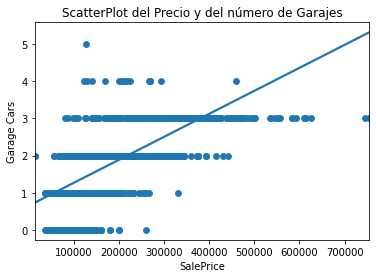

In [109]:
#Visualización
df_selected.plot.scatter(x="SalePrice", y="Garage Cars");
sns.regplot(x_df, y_df, ci=None); #create scatterplot with regression line
plt.xlabel('SalePrice') #NOMBRE EJE X
plt.ylabel('Garage Cars') #NOMBRE EJE Y
plt.title('ScatterPlot del Precio y del número de Garajes'); #TÍTULO

Podemos observar a simple vista, como a medida que aumenta el número de plazas de garaje, el precio de venta también aumenta, lo que indica una clara corelaccion positiva.

Un análisis posterior deberías ser el de obtener la media por cada grupo (numero de plazas de garaje) así como una distribución de su precio.

## 10.(COMPLEMENTARIA) Las 10 viviendas con mejores servicios y mejor precio.

No he sido capaz de realizarla